In [1]:
from keras.layers import Conv2D, Input, MaxPool2D,Flatten, Dense, Permute, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import adam
import numpy as np
import pickle
import keras
import cv2
import sys
import dlib
import os.path
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
import pickle
import numpy as np
import cv2
import os
from keras.layers import Dropout

Using TensorFlow backend.
/home/nariman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nariman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nariman/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nariman/.local/lib/python3.6/site-packages/tensorflow/py

Pretrained ResNet model

<img src="resnet50.png">

Final model

<img src="summary.png">

In [66]:
path = '../static/azat.jpg'
img = cv2.imread(path)

In [70]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('../model/models/shape_predictor_68_face_landmarks.dat')
rects = detector(img, 0)

In [75]:
from imutils import face_utils
# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(img, rect)
    shape = face_utils.shape_to_np(shape)

    # Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(img, (x, y), 2, (0, 255, 0), -1)

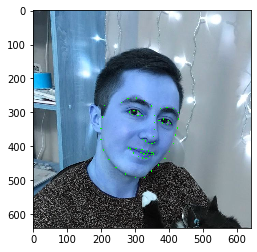

In [76]:
plt.imshow(img)

In [82]:
import itertools

ratios = []
points = shape
combinations = itertools.combinations(points, 4)
for cmb in combinations:
    d1 = np.linalg.norm(cmb[0] - cmb[1])
    d2 = np.linalg.norm(cmb[2] - cmb[3])
    ratio = d1 / d2
    ratios.append(ratio)


10.770329614269007

In [2]:
def score_mapping(modelScore):
    # weird shit
    # if modelScore <= 1.9:
    #     mappingScore = ((4 - 2.5) / (1.9 - 1.0)) * (modelScore-1.0) + 2.5
    # elif modelScore <= 2.8:
    #     mappingScore = ((5.5 - 4) / (2.8 - 1.9)) * (modelScore-1.9) + 4
    # elif modelScore <= 3.4:
    #     mappingScore = ((6.5 - 5.5) / (3.4 - 2.8)) * (modelScore-2.8) + 5.5
    # elif modelScore <= 4:
    #     mappingScore = ((8 - 6.5) / (4 - 3.4)) * (modelScore-3.4) + 6.5
    # elif modelScore < 5:
    #     mappingScore = ((9 - 8) / (5 - 4)) * (modelScore-4) + 8

    # either this or weird shit
    mappingScore = 2 * modelScore

    return mappingScore


In [6]:

model_path = '../model/models/mmod_human_face_detector.dat'
cnn_face_detector = dlib.cnn_face_detection_model_v1(model_path)

resnet = ResNet50(include_top=False, pooling='avg')
model = Sequential()
model.add(resnet)
model.add(Dense(5, activation='softmax'))
model.layers[0].trainable = False

model.load_weights('../model/models/model-ldl-resnet.h5')

In [37]:
path = '../static/azat.jpg'
im0 = cv2.imread(path)

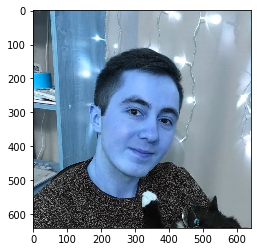

In [38]:
from matplotlib import pyplot as plt
plt.imshow(im0)

In [39]:
if im0.shape[0] > 1280:
    new_shape = (1280, im0.shape[1] * 1280 / im0.shape[0])
elif im0.shape[1] > 1280:
    new_shape = (im0.shape[0] * 1280 / im0.shape[1], 1280)
elif im0.shape[0] < 640 or im0.shape[1] < 640:
    new_shape = (im0.shape[0] * 2, im0.shape[1] * 2)
else:
    new_shape = im0.shape[0:2]

In [40]:
new_shape

(640, 640)

In [41]:
im = cv2.resize(im0, (int(new_shape[1]), int(new_shape[0])))
dets = cnn_face_detector(im, 0)
out = 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


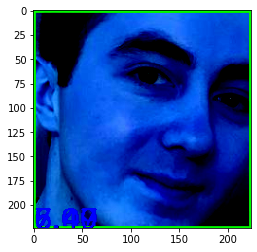

In [60]:
plt.imshow(normed_im[0])

In [63]:
out

6.48852424044162

In [52]:
for i, d in enumerate(dets):
    face = [d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()]
    croped_im = im[face[1]:face[3], face[0]:face[2], :]
    resized_im = cv2.resize(croped_im, (224, 224))
    normed_im = np.array([(resized_im - 127.5) / 127.5])
    pred = model.predict(normed_im)
    ldList = pred[0]
    out = 1 * ldList[0] + 2 * ldList[1] + 3 * ldList[2] + 4 * ldList[3] + 5 * ldList[4]

    out = score_mapping(out)

    # blur for privacy reasons
    # im = cv2.GaussianBlur(im, (101, 101), 0)

    # draw rectangle and score
    cv2.rectangle(im, (face[0], face[1]), (face[2], face[3]), (0, 255, 0), 3)
    cv2.putText(im, str('%.2f' % (out)), (face[0], face[3]), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2)



In [ ]:
# draw image
#path, ext = os.path.splitext(path)
#result_path = path + '.output' + ext
path, ext = os.path.splitext(path)
result_path = path.split('/')[0] + '/outputs/' + path.split('/')[1] + '.output' + ext

cv2.imwrite(result_path, im)
 